## Feature Selection Exercise
Peyton needs your help optimizing her campaign.  She wants to get more conversions and doesn't know which data features will help.  She has some campaign data she wants you to analyze.  In the campaign data file, you will find the following fields:

Hour of day
Segments
Device
Result (1=Conversion, 0=No Conversion)

Using Python and scikit-learn, identify the most predictive feature(s) for the result.  Please submit a zipped python file and a short explanation of your findings. 

### Data Cleaning
This data does not have any null values and is relatively clean. There are three features (hour, segments, device) and a target column ('result'). There's an almost equal split between 'Conversion' and 'No Conversion' results, making this data set well balanced. 

There is one column containing string values (device) that needs to be converted to integers before we implement feature selection techniques.

In [256]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn import preprocessing
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import LinearSVC
from numpy import loadtxt
from xgboost import XGBClassifier
from matplotlib import pyplot
from xgboost import plot_importance
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel
from numpy import sort
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import f_classif, chi2, mutual_info_classif
from sklearn.preprocessing import MinMaxScaler
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [257]:
campaign_data = pd.read_csv('campaign_data.csv')

In [258]:
campaign_data.head()

,hour,segments,device,result
0,9,51,Smartphone,1
1,9,51,Tablet,1
2,9,91,Smartphone,1
3,9,331,Desktop,1
4,9,41,Smartphone,1


In [259]:
campaign_data.shape

(3312, 4)

In [260]:
campaign_data.isnull().values.any()

False

In [261]:
campaign_data['device'].value_counts()

Smartphone    1403
Tablet        1098
Desktop        811
Name: device, dtype: int64

In [262]:
campaign_data['result'].value_counts()

1    1658
0    1654
Name: result, dtype: int64

In [263]:
df = campaign_data
le = preprocessing.LabelEncoder()
le.fit(df['device'])
df['device_int'] = le.transform(df['device'])
df = df[['hour', 'segments', 'device', 'device_int', 'result']]
print(df['device_int'].isnull().any())
print(dict(zip(df['device'], df['device_int'])))

False
{'Smartphone': 1, 'Tablet': 2, 'Desktop': 0}


In [264]:
df.head()

,hour,segments,device,device_int,result
0,9,51,Smartphone,1,1
1,9,51,Tablet,2,1
2,9,91,Smartphone,1,1
3,9,331,Desktop,0,1
4,9,41,Smartphone,1,1


### Exploratory Data Analysis
Certain hours of the day correlate with higher conversion rates. 

Text(0.5,0,'Hour')

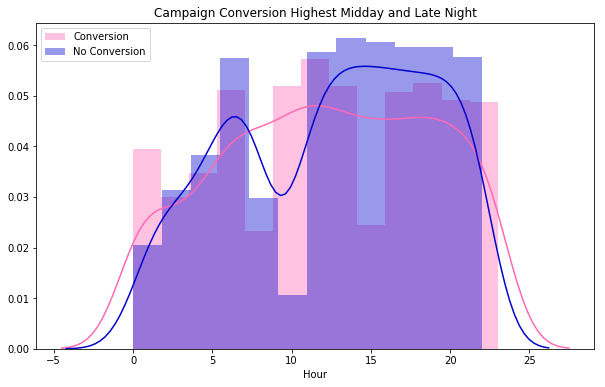

In [265]:
def distplot(feature):
    fig, ax = plt.subplots(1,1,figsize=(10,6))
    sns.distplot(df[feature][df['result']==1] ,color='hotpink', ax=ax)
    sns.distplot(df[feature][df['result']==0] ,color='mediumblue', ax=ax )
    plt.legend(['Conversion', 'No Conversion'])

distplot('hour')
plt.title('Campaign Conversion Highest Midday and Late Night')
plt.xlabel('Hour')

We see the highest conversion rates happen during lunch time (10 am to 12 pm). Around 3 pm, there is a significant decline in conversion rates, however it increases significantly at 4 pm and very slowly tapers down from 5 pm to midnight. The chances of non-conversion outweight conversion during the hours of 11 am to 9 pm, however, which is important to note, as it means that even if we campaign more in the evening, it may not be as sucessful as campaigning aggressively at midnight or 10 am, when the probability of conversion  is higher than the probability of non-conversion.

In [266]:
num = 10
hour_df = df[df['hour'] == num]
len(hour_df)

109

Text(0.5,0,'Device')

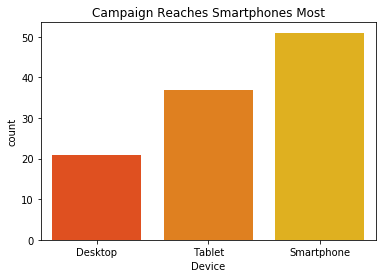

In [267]:
sns.countplot(hour_df['device'], palette=("autumn"))
plt.title('Campaign Reaches Smartphones Most')
plt.xlabel('Device')

Text(0.5,0,'Device')

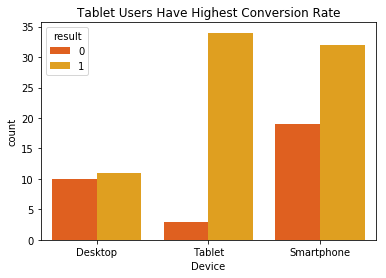

In [268]:
sns.countplot(hour_df['device'], palette=("autumn"), hue=hour_df['result'])
plt.title('Tablet Users Have Highest Conversion Rate')
plt.xlabel('Device')

If we isolate the hour in which we are most successful, 10 am, then we see that although our campain reaches more smartphone users, we are most successful with tablet users. Tablet users are around 11 times more likely to convert than not convert. To understand if the potential for tapping further into this opportunity, we can explore other time slots.

In [269]:
hour_df_two = df[df['hour'] != num]

Text(0.5,0,'Device')

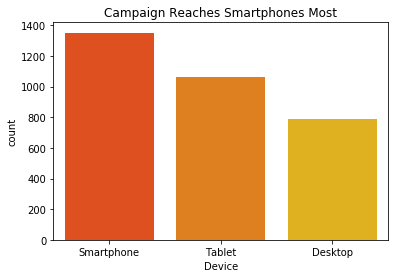

In [270]:
sns.countplot(hour_df_two['device'], palette=("autumn"))
plt.title('Campaign Reaches Smartphones Most')
plt.xlabel('Device')

Text(0.5,0,'Device')

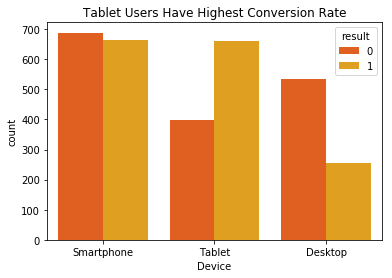

In [271]:
sns.countplot(hour_df_two['device'], palette=("autumn"), hue=hour_df_two['result'])
plt.title('Tablet Users Have Highest Conversion Rate')
plt.xlabel('Device')

When we look at the hours that are not 10 am, we see that tablets still performly strongly (in terms of probability), however the conversion rate is lower than it was at 10 am (nearly all tablet users at 10 am converted, whereas only half converted at hours that were not 10 am. This suggests that device may be a weaker feature for conversion prediction compared to hour.

In [272]:
num_two = 15
hour_df_three = df[df['hour'] == num_two]

Text(0.5,0,'Device')

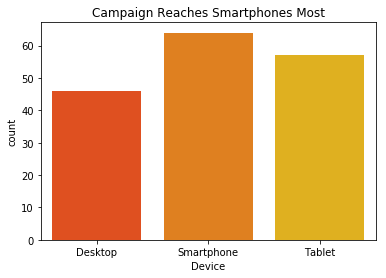

In [273]:
sns.countplot(hour_df_three['device'], palette=("autumn"))
plt.title('Campaign Reaches Smartphones Most')
plt.xlabel('Device')

Text(0.5,0,'Device')

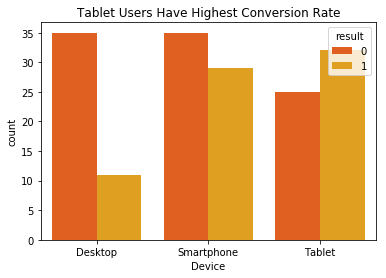

In [274]:
sns.countplot(hour_df_three['device'], palette=("autumn"), hue=hour_df_three['result'])
plt.title('Tablet Users Have Highest Conversion Rate')
plt.xlabel('Device')

The worst time for conversion was 3 pm (hour 15), when non-conversion count was highest, and converstion count was lowest. Tablet still performs better in terms of conversion probability, but is much weaker at 3 am than our previous comparisons. This supports the notion that hour is stronger at predicting conversion over device.

Text(0.5,0,'Device')

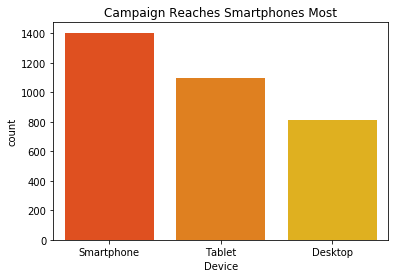

In [275]:
sns.countplot(df['device'], palette=("autumn"))
plt.title('Campaign Reaches Smartphones Most')
plt.xlabel('Device')

Text(0.5,0,'Device')

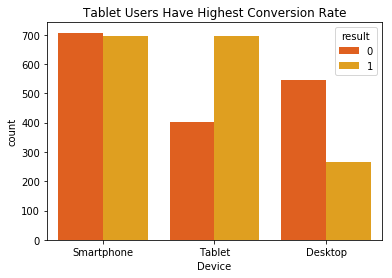

In [276]:
sns.countplot(df['device'], palette=("autumn"), hue=df['result'])
plt.title('Tablet Users Have Highest Conversion Rate')
plt.xlabel('Device')

In general, the success that we see overall in the tablet device is an average of a very successful hour for conversion at 10 am, when most tablet users converted. Tablet users do have a higher probability of conversion, but the device choice alone is not a good enough feature for prediction. 

Text(0.5,0,'Hour')

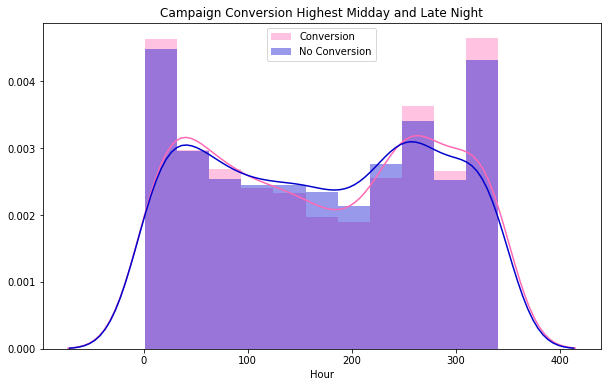

In [277]:
distplot('segments')
plt.title('Campaign Conversion Highest Midday and Late Night')
plt.xlabel('Hour')

From this distplot, we can see that segmentation itself does not look like a decisive factor because there are equal chances of conversoin and non conversion across all time periods. There is more activity within certain segments though (the first and last segment), and the last segment has the best conversion probability. We can drill down further to learn more about what causes this peak.

In [278]:
df['segments'].value_counts()[:5]

341    136
261    135
331    132
251    124
21     123
Name: segments, dtype: int64

In [279]:
df['segments'].value_counts()[-5:]

211    74
181    72
171    72
191    67
201    65
Name: segments, dtype: int64

In [280]:
seg = 341
segment_df = df[df['segments'] == seg]

Text(0.5,0,'Device')

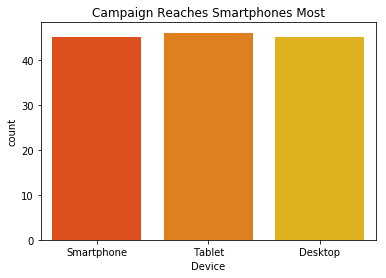

In [281]:
sns.countplot(segment_df['device'], palette=("autumn"))
plt.title('Campaign Reaches Smartphones Most')
plt.xlabel('Device')

Text(0.5,0,'Device')

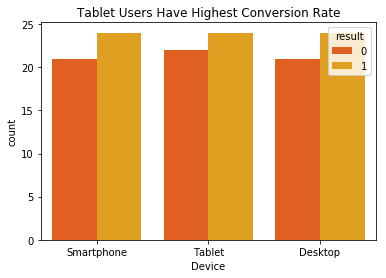

In [282]:
sns.countplot(segment_df['device'], palette=("autumn"), hue=segment_df['result'])
plt.title('Tablet Users Have Highest Conversion Rate')
plt.xlabel('Device')

In [283]:
segment_one = df[df['segments'] == 251]

Text(0.5,0,'Device')

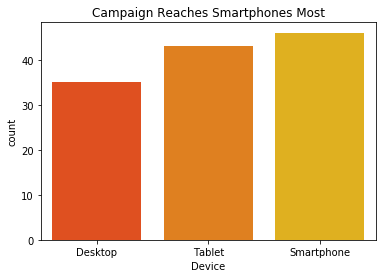

In [284]:
sns.countplot(segment_one['device'], palette=("autumn"))
plt.title('Campaign Reaches Smartphones Most')
plt.xlabel('Device')

Text(0.5,0,'Device')

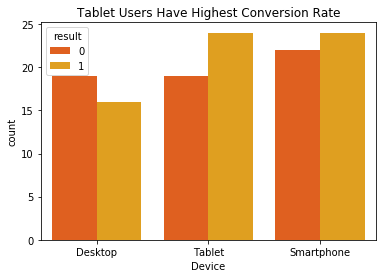

In [285]:
sns.countplot(segment_one['device'], palette=("autumn"), hue=segment_one['result'])
plt.title('Tablet Users Have Highest Conversion Rate')
plt.xlabel('Device')

In the segments with higher conversion probability than non-conversion, we see that there is no noticeable correlation between the device used and result. This means that device may not be a meaningful feature when paired with segments.

In [286]:
segment_df_two = df[df['segments'] == 201]

Text(0.5,0,'Device')

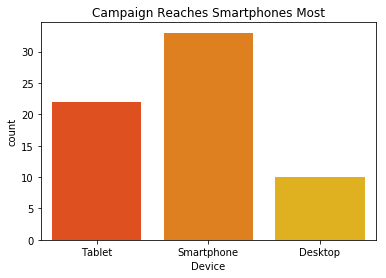

In [287]:
sns.countplot(segment_df_two['device'], palette=("autumn"))
plt.title('Campaign Reaches Smartphones Most')
plt.xlabel('Device')

Text(0.5,0,'Device')

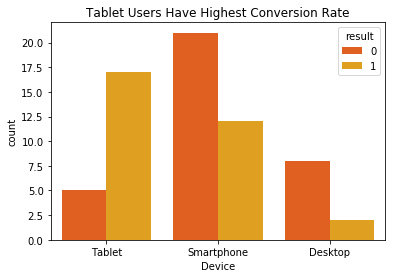

In [288]:
sns.countplot(segment_df_two['device'], palette=("autumn"), hue=segment_df_two['result'])
plt.title('Tablet Users Have Highest Conversion Rate')
plt.xlabel('Device')

With our most successful segment, segment 341, we see that there is no strong connection between the segment and device in terms of conversion rate. However, in our least successful segment, segment 201, we see that tablet users are most likely to convert. We can look at segments around it that performed similarly to verify this hypthesis.

In [289]:
segment_df_three = df[df['segments'] == 191]

Text(0.5,0,'Device')

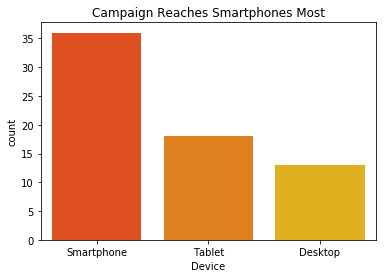

In [290]:
sns.countplot(segment_df_three['device'], palette=("autumn"))
plt.title('Campaign Reaches Smartphones Most')
plt.xlabel('Device')

Text(0.5,0,'Device')

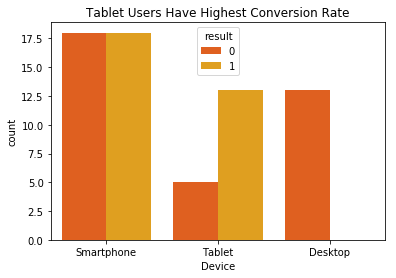

In [291]:
sns.countplot(segment_df_three['device'], palette=("autumn"), hue=segment_df_three['result'])
plt.title('Tablet Users Have Highest Conversion Rate')
plt.xlabel('Device')

In [292]:
segment_df_four = df[df['segments'] == 171]

Text(0.5,0,'Device')

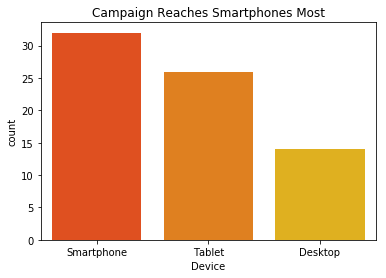

In [293]:
sns.countplot(segment_df_four['device'], palette=("autumn"))
plt.title('Campaign Reaches Smartphones Most')
plt.xlabel('Device')

Text(0.5,0,'Device')

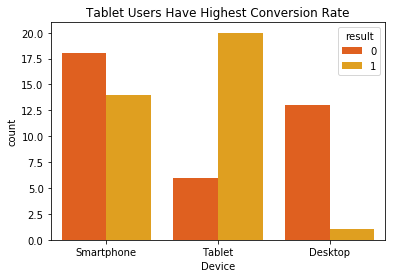

In [294]:
sns.countplot(segment_df_four['device'], palette=("autumn"), hue=segment_df_four['result'])
plt.title('Tablet Users Have Highest Conversion Rate')
plt.xlabel('Device')

In our least successful segments, where non-conversion was higher than conversion, we see that tablet users were much more likely to convert. This means that the device feature relies on the segment feature, and the segment feature could be important in helping us campain better.

Text(0.5,0,'Hour')

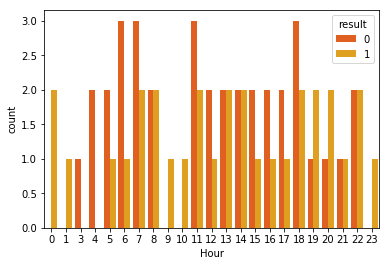

In [295]:
seg = 191
segment_df = df[df['segments'] == seg]
sns.countplot(segment_df['hour'], palette=("autumn"), hue=segment_df['result'])
plt.xlabel('Hour')

Text(0.5,0,'Hour')

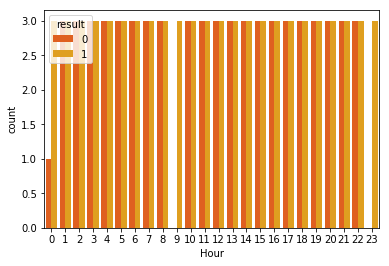

In [296]:
seg = 341
segment_df = df[df['segments'] == seg]
sns.countplot(segment_df['hour'], palette=("autumn"), hue=segment_df['result'])
plt.xlabel('Hour')

Text(0.5,0,'Hour')

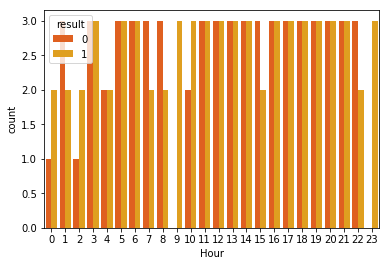

In [297]:
seg = 251
segment_df = df[df['segments'] == seg]
sns.countplot(segment_df['hour'], palette=("autumn"), hue=segment_df['result'])
plt.xlabel('Hour')

Text(0.5,0,'Segments')

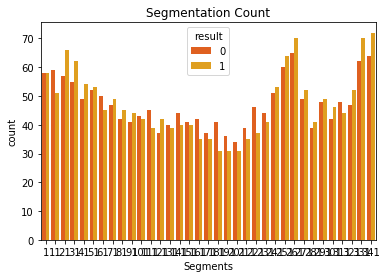

In [298]:
sns.countplot(df['segments'], palette=("autumn"), hue=df['result'])
plt.title('Segmentation Count')
plt.xlabel('Segments')

The patterns for different segments vary by each hour, meaning that the hour and segment features are both independent. The There are certain segments that are more successful in terms of conversion than others, and if we target specific devices in certain segments that can help us with our campaign. Targeting certain segments at specific hours can also help us encourage conversion.

### Modeling Data
From the exploratory data analysis, we hypothesize that time and segmentation are the strongest features for predicting which users will convert. This is because segmentation does not seem to correlate strongly with hour, meaning that the two paired together could be strong predictors. Targeting specific devices at specific times (such as tablet users at 10 am) looks like a strong strategy to consider, according to our analysis, so device paired with either feature could improve the accuracy of our model.

We build an ML pipeline to see which algorithm gives us the most accurate prediction for our data. From there, we can narrow down and see which features improve accuracy the most and plot feature importances to gather more support for our hypothesis.

In [299]:
! pip3 install xgboost --user
! pip3 install pdpbox --user

In [300]:
data = df[['hour', 'segments', 'device_int']]
target = df[['result']]

In [301]:
#Split data into 70% train, 30% validation (test) split
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size= 0.3, random_state=42)
X_train.shape

(2318, 3)

In [302]:
#Clean the data to either replace or remove string columns
X_train.dtypes

hour          int64
segments      int64
device_int    int64
dtype: object

In [303]:
#Build ML pipeline to perform quick analysis with classification algorithms
def quick_eval(pipeline, X_train, y_train, X_test, y_test, verbose=True):
    '''More advanced pipeline that uses DecisionTree,
    RandomForest, XGBoost, CatBoost and LightGBM as estimators'''
    
    pipeline.fit(X_train, y_train)
    y_train_pred = pipeline.predict(X_train)
    y_test_pred = pipeline.predict(X_test)
    
    train_score = pipeline.score(X_train, y_train)
    test_score = pipeline.score(X_test, y_test)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    s = [train_score, test_score, train_rmse, test_rmse, train_r2, test_r2]
    s_df = pd.DataFrame(s, columns=[pipeline.named_steps['classification'].__class__.__name__], 
                        index=['train_score', 'test_score', 'train_rmse', 'test_rmse',
                              'train_r2', 'test_r2'])
    return s_df
    
classifiers = [
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    ExtraTreesClassifier(),
    XGBClassifier(),
    KNeighborsClassifier(),
    BaggingClassifier()
]

score_df = pd.DataFrame()

for c in classifiers:
    pipe = Pipeline(steps = [
        ('minmax', MinMaxScaler()),
        ('classification', c)
    ])

    result_df = quick_eval(pipe, X_train, y_train, X_test, y_test)
    score_df = pd.concat([score_df, result_df], axis=1)
    
score_df

,DecisionTreeClassifier,RandomForestClassifier,ExtraTreesClassifier,XGBClassifier,KNeighborsClassifier,BaggingClassifier
train_score,0.751079,0.746333,0.751079,0.643227,0.667817,0.747627
test_score,0.343058,0.364185,0.349095,0.586519,0.479879,0.355131
train_rmse,0.498920,0.503654,0.498920,0.597305,0.576353,0.502367
test_rmse,0.810519,0.797380,0.806787,0.643025,0.721194,0.803037
train_r2,0.004017,-0.014970,0.004017,-0.427517,-0.329127,-0.009792
test_r2,-1.631218,-1.546600,-1.607041,-0.656096,-1.083215,-1.582865


From our ML pipeline, we see that the tree classifiers perform best, with the DecisionTreeClassifier and ExtraTreesClassifier performing better than the Random Forest Classifier. We can dig inot the feature importance modules of tree classifiers to understand what features were most prominent in these algorithms.

In [304]:
clf = DecisionTreeClassifier().fit(data, target)
dict(zip(data.columns, clf.feature_importances_))

{'device_int': 0.17374261229905641,
 'hour': 0.45973311397304267,
 'segments': 0.36652427372790103}

The Decision Tree Classifier feature importances attribute shows us that the hour and segments features are prominent in predicting conversion, whereas the device is not nearly as important.

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Feature ranking:
1. feature 0 (0.516753)
2. feature 1 (0.383461)
3. feature 2 (0.099786)


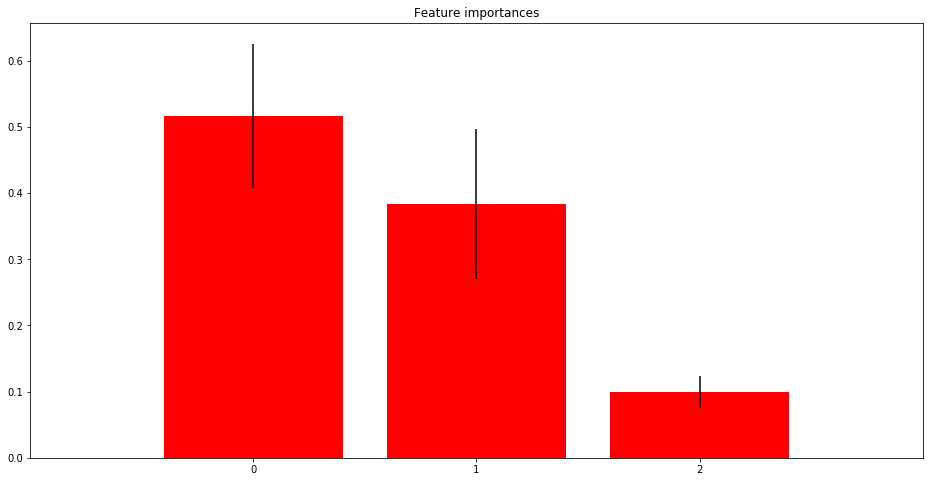

In [305]:
# Build a forest and compute the feature importances
forest = RandomForestClassifier(n_estimators=250,
                              random_state=0)

n_features = 3
forest.fit(X_train, y_train)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(n_features):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(16,8))
plt.title("Feature importances")
plt.bar(range(n_features), importances[indices][:n_features],
       color="r", yerr=std[indices][:n_features], align="center")
plt.xticks(range(n_features), indices)
plt.xlim([-1, n_features])
plt.show()

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  



Random Forest
Accuracy on training set: 0.751
Accuracy on test set: 0.359


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Random Forest - Max Depth = 3
Accuracy on training set: 0.621
Accuracy on test set: 0.591

Random Forest Feature Importance


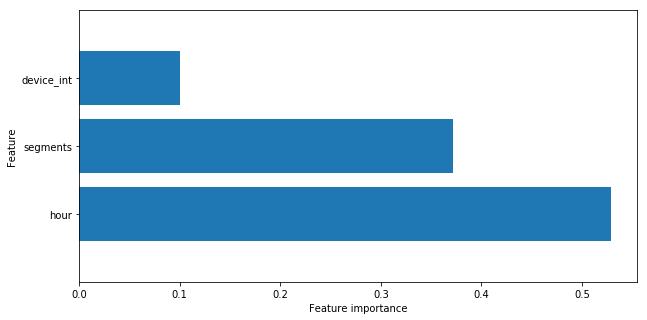

In [306]:
X_train_features = [x for i,x in enumerate(X_train) if i!=8]

def plot_feature_importances_costa(model):
    plt.figure(figsize=(10,5))
    n_features = 3
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), X_train_features)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)
    plt.show()

rf = RandomForestClassifier(n_estimators=100, random_state=0)
rf.fit(X_train, y_train)
print("")
print('Random Forest')
print("Accuracy on training set: {:.3f}".format(rf.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(rf.score(X_test, y_test)))

rf1 = RandomForestClassifier(max_depth=3, n_estimators=100, random_state=0)
rf1.fit(X_train, y_train)
print("")
print('Random Forest - Max Depth = 3')
print("Accuracy on training set: {:.3f}".format(rf1.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(rf1.score(X_test, y_test)))

print("")
print('Random Forest Feature Importance')
plot_feature_importances_costa(rf)

The feature importance of the Random Forest Classifier supports the feature importance of the Decision Tree Classifier - hour and segments are both more important than device. This could be because hour and segments are not correlated with each other, and due to this lack of correlation, they can work better together to predict conversion, rather than with the device feature, which seems to mildly correlate with both the hour and segments feature.

In [307]:
X = data.values
Y = target.values

In [308]:
model = ExtraTreesClassifier(n_estimators=10)
model.fit(X, Y)
print(model.feature_importances_)

[ 0.43705068  0.34414446  0.21880486]


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


### Feature Extraction + Modeling
Using the results from our first round of modeling and feature importance plots, we can try to improve the accuracy of our results by picking out the hour and segments feature and running our ML pipeline again. We can also run our hypothesis (hours and device are best features). If the results improve, then we know that these features are better at predicting conversion than using all three features. If not, we can see if our exploratory data analysis and hypothesis are stronger than the feature importance plots offered by sklearn.

In [309]:
features_hypothesis = df[['hour', 'device_int']]

In [310]:
#Split data into 70% train, 30% validation (test) split
X_train, X_test, y_train, y_test = train_test_split(features_hypothesis, target, test_size= 0.5, random_state=42)
X_train.shape

(1656, 2)

In [311]:
classifiers = [
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    ExtraTreesClassifier(),
    XGBClassifier(),
    KNeighborsClassifier(),
    BaggingClassifier()
]

score_df = pd.DataFrame()

for c in classifiers:
    pipe = Pipeline(steps = [
        ('minmax', MinMaxScaler()),
        ('classification', c)
    ])

    result_df = quick_eval(pipe, X_train, y_train, X_test, y_test)
    score_df = pd.concat([score_df, result_df], axis=1)
    
score_df

,DecisionTreeClassifier,RandomForestClassifier,ExtraTreesClassifier,XGBClassifier,KNeighborsClassifier,BaggingClassifier
train_score,0.640097,0.637681,0.640097,0.635266,0.614734,0.637681
test_score,0.591787,0.597222,0.591787,0.611715,0.582729,0.592391
train_rmse,0.599919,0.601929,0.599919,0.603932,0.620698,0.601929
test_rmse,0.638915,0.634648,0.638915,0.623125,0.645965,0.638442
train_r2,-0.440025,-0.449690,-0.440025,-0.459354,-0.541503,-0.449690
test_r2,-0.633193,-0.611450,-0.633193,-0.553466,-0.669433,-0.630777


In [312]:
features_observed = df[['hour', 'segments']]

In [313]:
#Split data into 70% train, 30% validation (test) split
X_train, X_test, y_train, y_test = train_test_split(features_observed, target, test_size= 0.5, random_state=42)
X_train.shape

(1656, 2)

In [314]:
classifiers = [
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    ExtraTreesClassifier(),
    XGBClassifier(),
    KNeighborsClassifier(),
    BaggingClassifier()
]

score_df = pd.DataFrame()

for c in classifiers:
    pipe = Pipeline(steps = [
        ('minmax', MinMaxScaler()),
        ('classification', c)
    ])

    result_df = quick_eval(pipe, X_train, y_train, X_test, y_test)
    score_df = pd.concat([score_df, result_df], axis=1)
    
score_df

,DecisionTreeClassifier,RandomForestClassifier,ExtraTreesClassifier,XGBClassifier,KNeighborsClassifier,BaggingClassifier
train_score,0.717995,0.705314,0.717995,0.611715,0.647947,0.710145
test_score,0.423309,0.417874,0.418478,0.516908,0.453502,0.419082
train_rmse,0.531041,0.542850,0.531041,0.623125,0.593341,0.538382
test_rmse,0.759402,0.762972,0.762576,0.695048,0.739255,0.762180
train_r2,-0.128342,-0.179081,-0.128342,-0.553584,-0.408615,-0.159752
test_r2,-1.307248,-1.328992,-1.326576,-0.932773,-1.186450,-1.324160


In [315]:
features_all = df[['hour', 'segments', 'device_int']]

In [316]:
#Split data into 70% train, 30% validation (test) split
X_train, X_test, y_train, y_test = train_test_split(features_all, target, test_size= 0.5, random_state=42)
X_train.shape

(1656, 3)

In [317]:
classifiers = [
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    ExtraTreesClassifier(),
    XGBClassifier(),
    KNeighborsClassifier(),
    BaggingClassifier()
]

score_df = pd.DataFrame()

for c in classifiers:
    pipe = Pipeline(steps = [
        ('minmax', MinMaxScaler()),
        ('classification', c)
    ])

    result_df = quick_eval(pipe, X_train, y_train, X_test, y_test)
    score_df = pd.concat([score_df, result_df], axis=1)
    
score_df

,DecisionTreeClassifier,RandomForestClassifier,ExtraTreesClassifier,XGBClassifier,KNeighborsClassifier,BaggingClassifier
train_score,0.812802,0.800121,0.812802,0.655797,0.676932,0.798913
test_score,0.406401,0.424517,0.414251,0.590580,0.518720,0.432971
train_rmse,0.432664,0.447079,0.432664,0.586688,0.568390,0.448427
test_rmse,0.770454,0.758606,0.765342,0.639860,0.693744,0.753013
train_r2,0.250994,0.200254,0.250994,-0.377205,-0.292640,0.195422
test_r2,-1.374895,-1.302416,-1.343487,-0.638025,-0.925525,-1.268592


With regards to our test, we can see that our hypothesis provided us with a better test score, but the feature importances suggestion provided us with a better training score. We can see that using all three features with a 50/50 train/test split provides us with the best accuracy. This means that we benefit from using all three features, although the hour and segments features are more important in determining conversion than if either were paired with the device feature.

In summary, we can see that the most predictive features are hour, followed by segments. We see in our exploratory data analysis that there are certain hours that correlate with a higher likelihood of conversion, and if we pair it a certain device, that likelihood increases. We also see that there are certain segments that are likely to convert and that if we target those segments at certain hours, we can increase chances of conversion. This makes the best features hour, followed second by segments.